In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from MODULES.utilities import load_obj
import torch
import numpy as np
from scipy.sparse import coo_matrix
import networkx as nx
import community as community_louvain
import skimage.color
import time
import functools 


#!pip install python-louvain

### Load the multichannel segmentation mask

In [2]:
!pip install cugraph

  ERROR: Command errored out with exit status 1:
   command: /Users/ldalessi/anaconda3/envs/pyro/bin/python3.8 -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'/private/var/folders/vp/jc2pp92s1ws3396qpk30yl01ft5h_t/T/pip-install-ycpnoqu8/cugraph/setup.py'"'"'; __file__='"'"'/private/var/folders/vp/jc2pp92s1ws3396qpk30yl01ft5h_t/T/pip-install-ycpnoqu8/cugraph/setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d /private/var/folders/vp/jc2pp92s1ws3396qpk30yl01ft5h_t/T/pip-wheel-az1wulbk
       cwd: /private/var/folders/vp/jc2pp92s1ws3396qpk30yl01ft5h_t/T/pip-install-ycpnoqu8/cugraph/
  Complete output (25 lines):
  running bdist_wheel
  running build
  installing to build/bdist.macosx-10.9-x86_64/wheel
  running install
  Traceback (most recent call last):
    File "<string>", line 1, in <module>
    File "/private/var/folders/vp/jc2pp92s1ws3

In [1]:
import cugraph
import cudf

ModuleNotFoundError: No module named 'cugraph'

In [3]:
mask_file = "/Users/ldalessi/DAPI_unsupervised/spacetx-research/merfish_june23_v1/seg_mask_multichannels.pkl"


integer_seg_mask, raw_img = load_obj(mask_file)
print(integer_seg_mask.shape, raw_img.shape)

torch.Size([16, 500, 500]) torch.Size([1, 500, 500])


### Segmentation Mask produced with Sliding window has boundary effect

In [4]:
n_cells = torch.max(integer_seg_mask.flatten(start_dim=1),dim=-1)[0]
print(n_cells)

tensor([430, 424, 403, 392, 423, 417, 397, 393, 426, 414, 394, 394, 405, 403,
        392, 380])


Text(0.5, 1.0, 'raw image')

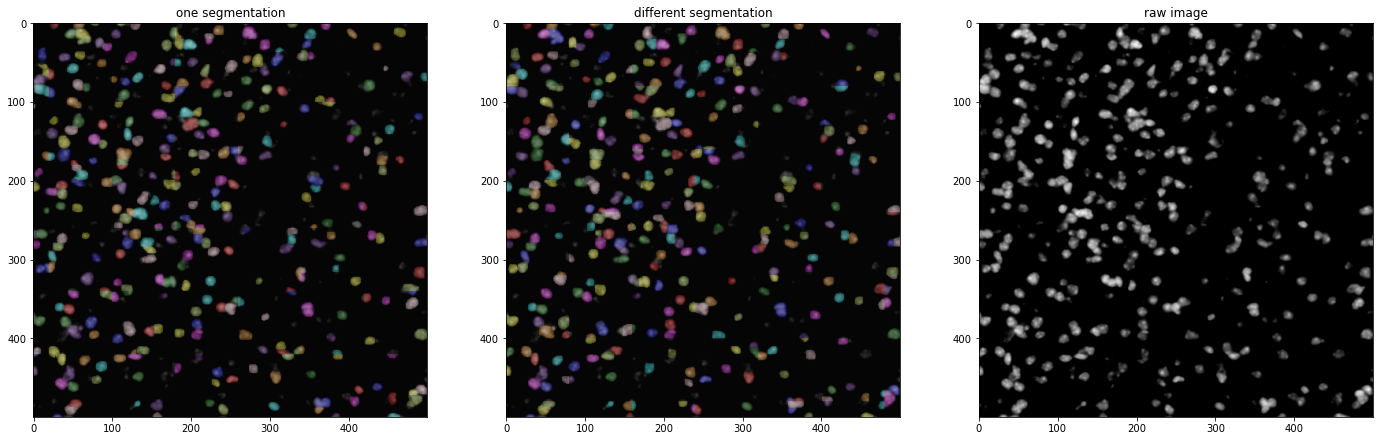

In [5]:
label0 = (integer_seg_mask[0] % 255).cpu().numpy()
label1 = (integer_seg_mask[-1] % 255).cpu().numpy()
img = raw_img[0].cpu().numpy()


figure, axes = plt.subplots(ncols=3, figsize=(24, 24))
axes[0].imshow(skimage.color.label2rgb(label0, img, alpha=0.25, bg_label=0))
axes[1].imshow(skimage.color.label2rgb(label1, img, alpha=0.25, bg_label=0))
axes[2].imshow(img, cmap='gray')
axes[0].set_title("one segmentation")
axes[1].set_title("different segmentation")
axes[2].set_title("raw image")

### Zoomed version

Text(0.5, 1.0, 'raw image')

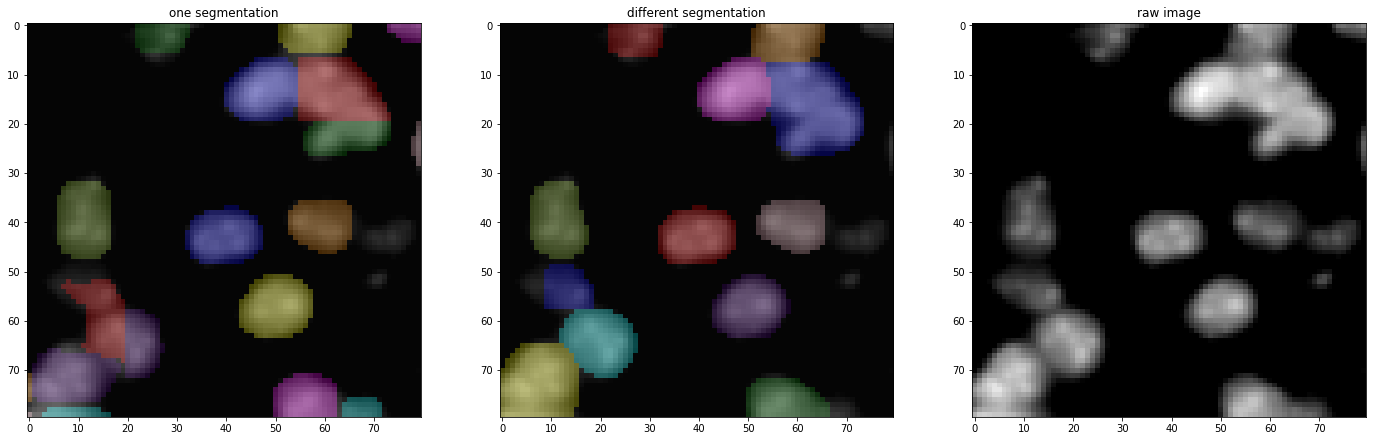

In [6]:
figure, axes = plt.subplots(ncols=3, figsize=(24, 24))

axes[0].imshow(skimage.color.label2rgb(label0[:80,:80], img[:80,:80], alpha=0.25, bg_label=0))
axes[1].imshow(skimage.color.label2rgb(label1[:80,:80], img[:80,:80], alpha=0.25, bg_label=0))
axes[2].imshow(img[:80,:80], cmap='gray')
axes[0].set_title("one segmentation")
axes[1].set_title("different segmentation")
axes[2].set_title("raw image")

### Here I do the geraph cutting, i.e. consensus segmentation

In [159]:
class ConsensusSegmentation():
    """ Takes many integer segmentation masks and produce a consensus segmentation mask.
        It does so by producing a graph in which each node is a foreground pixel and each edge
        is the number of times two pixel are segmented in the same object. 
        
        Typical usage:
        consensus = ConsensusSegmentation(integer_segmentation_masks)
        mask = consensus.mask()
    """
    
    def __init__(self, integer_masks):
        super().__init__()
        
        # size = ch, w, h. Contains the labels bg=0, fg= 1,2,...
        assert len(integer_masks.shape) == 3 
        
        self.integer_mask = integer_masks
        self.device = self.integer_mask.device
        self.ch, self.nx, self.ny = self.integer_mask.shape
        self.fg_mask = (torch.sum(self.integer_mask, dim=-3) > 0)
        
        ix_matrix, iy_matrix = torch.meshgrid([torch.arange(self.nx, dtype=int, device=self.device), 
                                               torch.arange(self.ny, dtype=int, device=self.device)])
        self.x_coordinate_fg_pixel = ix_matrix[self.fg_mask]
        self.y_coordinate_fg_pixel = iy_matrix[self.fg_mask]
        self.n_fg_pixel = self.x_coordinate_fg_pixel.shape[0]
        self.index_array = torch.arange(self.n_fg_pixel, dtype=int, device=self.device)
        self.index_matrix = torch.zeros_like(ix_matrix)
        self.index_matrix[self.x_coordinate_fg_pixel, 
                          self.y_coordinate_fg_pixel] = self.index_array
        
        partition_tmp = self.integer_mask[0,
                                          self.x_coordinate_fg_pixel, 
                                          self.y_coordinate_fg_pixel]
        self.initial_partition = dict(zip(self.index_array.numpy(),partition_tmp.numpy()))
        
        
        print("n_fg_pixel -->",self.n_fg_pixel)
        
        
        
    @functools.lru_cache(maxsize=10)  
    def mask(self, d_max=1, resolution=1):
        return self.compute_mask(d_max, resolution)
    
    
    partition = la.find_partition(igraph, la.CPMVertexPartition, 
                              resolution_parameter = 0.03, 
                              initial_membership = c.integer_mask[0][c.fg_mask],
                              weights=igraph.es['weight'])

optimiser = la.Optimiser()
diff = optimiser.optimise_partition(partition, n_iterations=10)

optimiser = la.Optimiser()
profile_with_w = optimiser.resolution_profile(igraph, la.CPMVertexPartition,
                                              resolution_range=(0,1),
                                              weights=igraph.es['weight'])




    
    @functools.lru_cache(maxsize=10) 
    def S_NN(self, d_max=1):
        return self.compute_SNN(d_max)
        
    def compute_SNN(self, d_max):
        """ Build the Nearest Neightbor graph with radius d_max """
        print("Setting value SNN")
        result = None
        for dx in range(-d_max,d_max+1):
            index_tmp = torch.roll(self.index_matrix, dx, dims=-2)
            mask_tmp = torch.roll(self.integer_mask, dx, dims=-2)
            for dy in range(-d_max,d_max+1):
                index_shifted = torch.roll(index_tmp, dy, dims=-1)
                mask_shifted = torch.roll(mask_tmp, dy, dims=-1)
                if(dx==0 and dy==0):
                    continue
                else:
                    edge = torch.sum(self.integer_mask == mask_shifted, dim=-3)
                    
                    i_tmp= self.index_matrix[self.fg_mask]
                    j_tmp = index_shifted[self.fg_mask]
                    v_tmp = edge[self.fg_mask]
                    
                    select = (v_tmp > 0)
                    i = i_tmp[select].numpy()
                    j = j_tmp[select].numpy()
                    v = v_tmp[select].numpy()
                    
                    M = coo_matrix((v, (i, j)), dtype='int', shape=(self.n_fg_pixel,self.n_fg_pixel))
                    result = M if result is None else result + M
                    
        return result
        
    
    def compute_mask(self, d_max, resolution):
        """ Perform Louvaine algorithm at a given resolution """

        graph = nx.from_scipy_sparse_matrix(self.S_NN(d_max))

        print("--- Starting Louvain Algorithm ---")
        start_time = time.time()
        partition = community_louvain.best_partition(graph, 
                                                     partition=None, #self.initial_partition,
                                                     resolution=resolution, 
                                                     randomize=True)
        print("--- Louvain Algorithm time -> %s seconds ---" % (time.time() - start_time))
                    
        assert (torch.tensor(list(partition.keys())) == self.index_array).all()
        instace_IDs = torch.tensor(list(partition.values())) + 1  # +1 b/c label_bg=0, label_fg=1,2,...
                
        # Write data using left indexing (very fast)
        consensus_mask = torch.zeros_like(self.index_matrix)
        consensus_mask[self.x_coordinate_fg_pixel, self.y_coordinate_fg_pixel] = instace_IDs
        
        return consensus_mask

In [160]:
#consensus = ConsensusSegmentation(integer_seg_mask[:,:80,:80])
consensus = ConsensusSegmentation(integer_seg_mask)

n_fg_pixel --> 47081
Setting value SNN
--- Starting Louvain Algorithm ---
--- Louvain Algorithm time -> 33.35423183441162 seconds ---


In [161]:
mask_1 = consensus.mask(d_max=1, resolution=1)
mask_10 = consensus.mask(d_max=1, resolution=10)
mask_01 = consensus.mask(d_max=1, resolution=0.1)

--- Starting Louvain Algorithm ---
--- Louvain Algorithm time -> 30.799896955490112 seconds ---
--- Starting Louvain Algorithm ---
--- Louvain Algorithm time -> 31.1836838722229 seconds ---


### RESULT 1: resolution=1

In [162]:
label0 = consensus.integer_mask[0].numpy()
label1 = consensus.integer_mask[-1].numpy()
label2 = mask_1.numpy()

430 380 304


Text(0.5, 1.0, 'raw image')

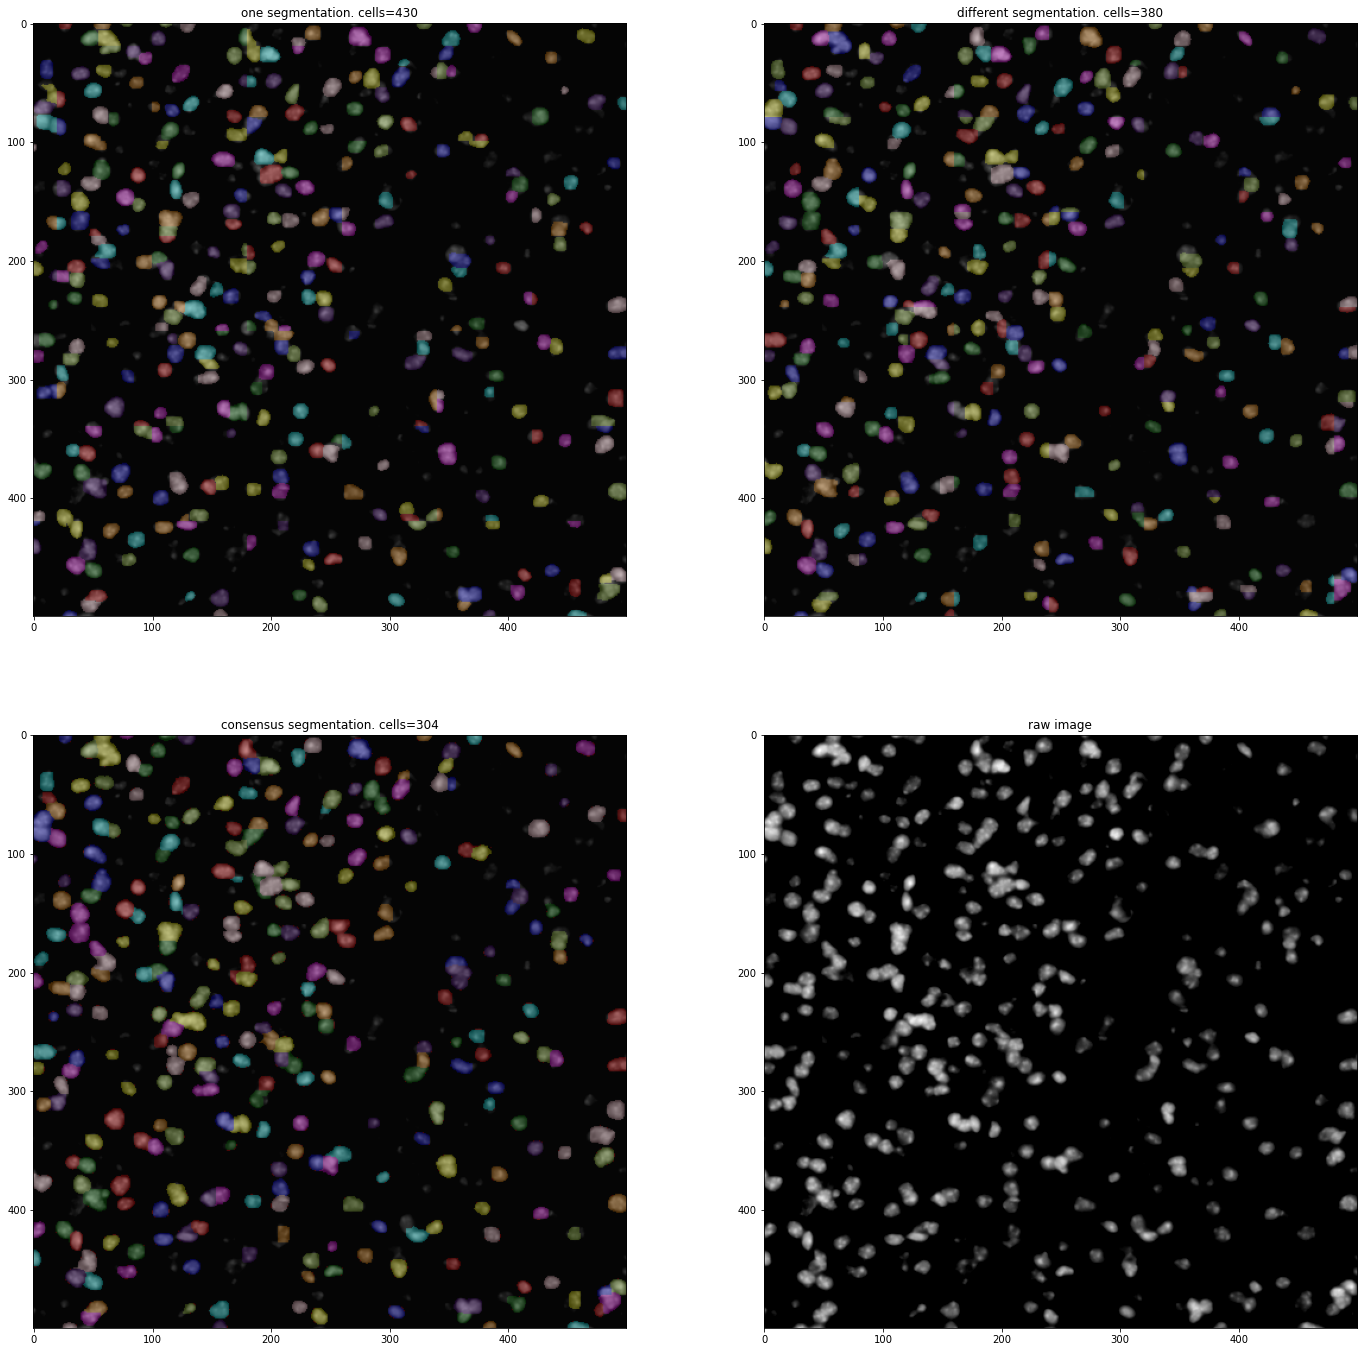

In [168]:
n0 = np.max(label0).item()
n1 = np.max(label1).item()
n2 = np.max(label2).item()
print(n0,n1,n2)

figure, axes = plt.subplots(ncols=2, nrows=2, figsize=(24, 24))
axes[0,0].imshow(skimage.color.label2rgb(label0 % 255, img, alpha=0.25, bg_label=0))
axes[0,1].imshow(skimage.color.label2rgb(label1 % 255, img, alpha=0.25, bg_label=0))
axes[1,0].imshow(skimage.color.label2rgb(label2 % 255, img, alpha=0.25, bg_label=0))
axes[1,1].imshow(img, cmap='gray')
axes[0,0].set_title("one segmentation. cells="+str(n0))
axes[0,1].set_title("different segmentation. cells="+str(n1))
axes[1,0].set_title("consensus segmentation. cells="+str(n2))
axes[1,1].set_title("raw image")

### ZOOMED RESULT 1: resolution=1

218 345


Text(0.5, 1.0, 'raw image')

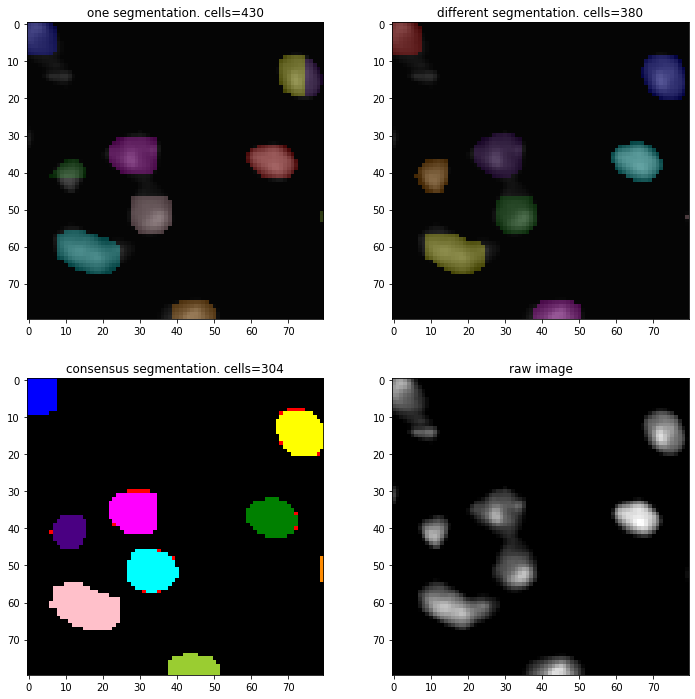

In [183]:
dx, dy = 80, 80
ix = np.random.randint(low=0, high=img.shape[-2]-dx, size=[1]).item()
iy = np.random.randint(low=0, high=img.shape[-1]-dy, size=[1]).item()
print(ix,iy)

figure, axes = plt.subplots(ncols=2, nrows=2, figsize=(12, 12))
axes[0,0].imshow(skimage.color.label2rgb(label0[ix:(ix+dx),iy:(iy+dy)], img[ix:(ix+dx),iy:(iy+dy)], alpha=0.25, bg_label=0))
axes[0,1].imshow(skimage.color.label2rgb(label1[ix:(ix+dx),iy:(iy+dy)], img[ix:(ix+dx),iy:(iy+dy)], alpha=0.25, bg_label=0))
axes[1,0].imshow(skimage.color.label2rgb(label2[ix:(ix+dx),iy:(iy+dy)], img[ix:(ix+dx),iy:(iy+dy)], alpha=1.0, bg_label=0))
axes[1,1].imshow(img[ix:(ix+dx),iy:(iy+dy)], cmap='gray')
axes[0,0].set_title("one segmentation. cells="+str(n0))
axes[0,1].set_title("different segmentation. cells="+str(n1))
axes[1,0].set_title("consensus segmentation. cells="+str(n2))
axes[1,1].set_title("raw image")

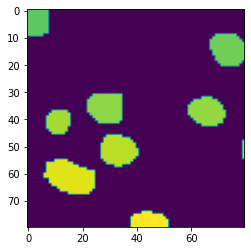

In [185]:
a = label2[218:(218+80),345:(345+80)]
plt.imshow(a)


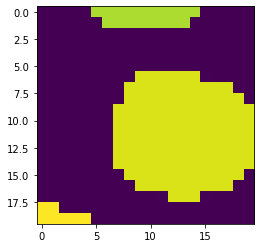

In [188]:
b = a[40:60,20:40]
plt.imshow(b)

### RESULT 2: resolution=0.1

In [165]:
label0 = consensus.integer_mask[0].numpy()
label1 = consensus.integer_mask[-1].numpy()
label2 = mask_01.numpy()

430 380 304


Text(0.5, 1.0, 'raw image')

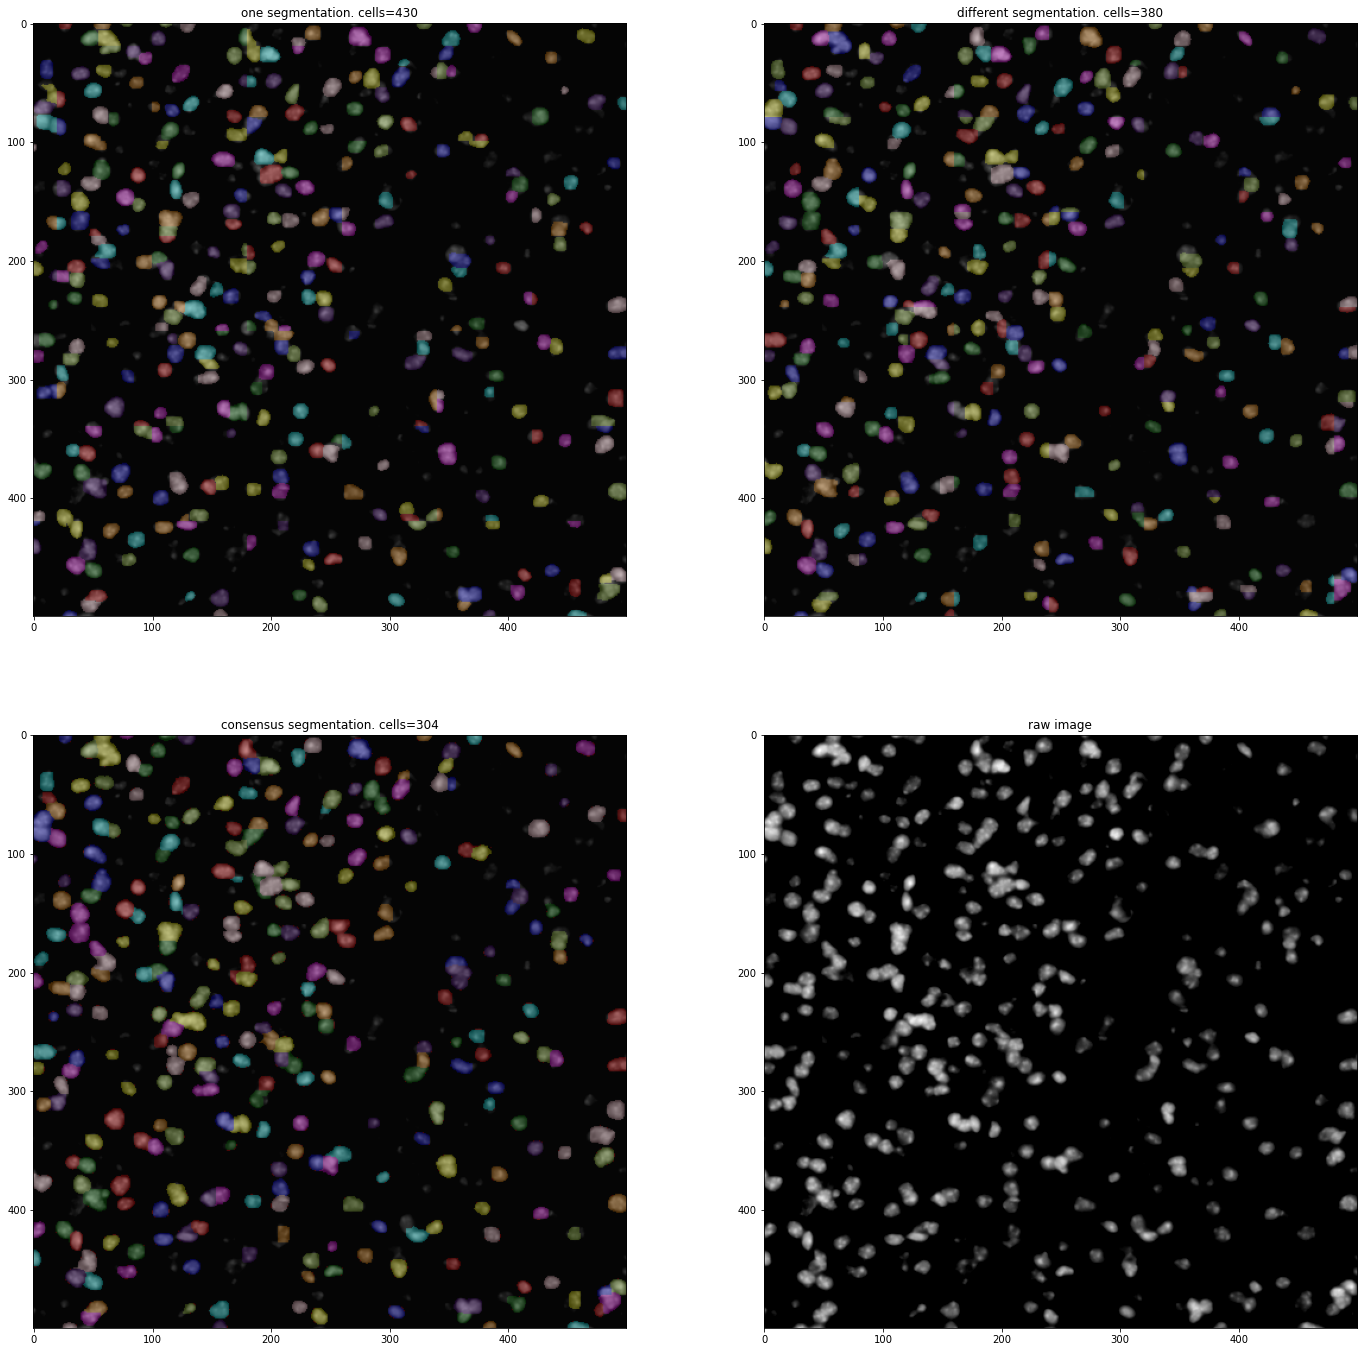

In [166]:
n0 = np.max(label0).item()
n1 = np.max(label1).item()
n2 = np.max(label2).item()
print(n0,n1,n2)

figure, axes = plt.subplots(ncols=2, nrows=2, figsize=(24, 24))
axes[0,0].imshow(skimage.color.label2rgb(label0 % 255, img, alpha=0.25, bg_label=0))
axes[0,1].imshow(skimage.color.label2rgb(label1 % 255, img, alpha=0.25, bg_label=0))
axes[1,0].imshow(skimage.color.label2rgb(label2 % 255, img, alpha=0.25, bg_label=0))
axes[1,1].imshow(img, cmap='gray')
axes[0,0].set_title("one segmentation. cells="+str(n0))
axes[0,1].set_title("different segmentation. cells="+str(n1))
axes[1,0].set_title("consensus segmentation. cells="+str(n2))
axes[1,1].set_title("raw image")

### ZOOMED RESULT 2: resolution=0.1

Text(0.5, 1.0, 'raw image')

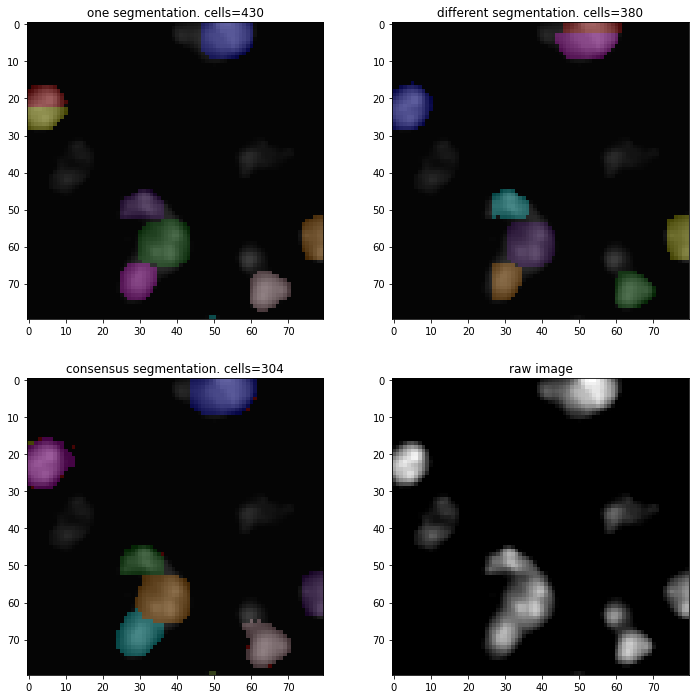

In [167]:
dx, dy = 80, 80
ix = np.random.randint(low=0, high=img.shape[-2]-dx, size=[1]).item()
iy = np.random.randint(low=0, high=img.shape[-1]-dy, size=[1]).item()

figure, axes = plt.subplots(ncols=2, nrows=2, figsize=(12, 12))
axes[0,0].imshow(skimage.color.label2rgb(label0[ix:(ix+dx),iy:(iy+dy)], img[ix:(ix+dx),iy:(iy+dy)], alpha=0.25, bg_label=0))
axes[0,1].imshow(skimage.color.label2rgb(label1[ix:(ix+dx),iy:(iy+dy)], img[ix:(ix+dx),iy:(iy+dy)], alpha=0.25, bg_label=0))
axes[1,0].imshow(skimage.color.label2rgb(label2[ix:(ix+dx),iy:(iy+dy)], img[ix:(ix+dx),iy:(iy+dy)], alpha=0.25, bg_label=0))
axes[1,1].imshow(img[ix:(ix+dx),iy:(iy+dy)], cmap='gray')
axes[0,0].set_title("one segmentation. cells="+str(n0))
axes[0,1].set_title("different segmentation. cells="+str(n1))
axes[1,0].set_title("consensus segmentation. cells="+str(n2))
axes[1,1].set_title("raw image")